# Fetal-adult comparison

In [1]:
library(tidyverse)
library(data.table)
library(qvalue)
library(RColorBrewer)
library(VennDiagram)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

Loading required package: futile.logger



### 1: Permutation eGene
- Note our data has TOPMed variants

In [2]:
fetal <- read.table("../results/mixed_perm_90hcp/all_assoc.txt.gz", header = T, stringsAsFactors = F)
head(fetal)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05
2,ENSG00000000457,7094,1.04721,695.715,467.037,rs761499672,-797092,4.58351e-05,0.174268,0.07059290,7.57180e-02,8.87792e-02,6.25971e-05
3,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05
4,ENSG00000000938,4365,1.01977,476.482,465.432,rs74060542,-40678,3.55489e-04,0.328784,0.31717400,3.13974e-01,2.30595e-01,8.28194e-05
5,ENSG00000000971,4671,1.02585,532.868,474.412,rs113887390,-792723,6.47444e-04,0.455490,0.48171300,4.74379e-01,2.93544e-01,7.57214e-05
6,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05


In [3]:
dim(fetal)

[1] 31531    13

In [4]:
gtex <- fread("/u/project/gandalm/shared/GenomicDatasets/GTEx/GTEx_Analysis_v8_eQTL/Brain_Cortex.v8.egenes.txt.gz"
                   , data.table = F)
head(gtex)

,gene_id,gene_name,gene_chr,gene_start,gene_end,strand,num_var,beta_shape1,beta_shape2,true_df,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,log2_aFC,log2_aFC_lower,log2_aFC_upper
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232.5,WASH7P,chr1,14410,29553,-,1364,1.03067,279.260,150.530,...,6.69151e-05,-2.278650,0.556933,0.03299670,0.034327700,0.037693800,0.000199956,-6.643856,-6.643856,-6.643856
2,ENSG00000268903.1,RP11-34P13.15,chr1,135141,135895,-,1863,1.04288,330.819,147.050,...,8.58837e-04,-0.717460,0.211310,0.40509900,0.401187000,0.213474000,0.000175730,-3.405266,-6.643856,-0.949213
3,ENSG00000269981.1,RP11-34P13.16,chr1,137682,137965,-,1868,1.08579,294.051,142.506,...,2.28982e-03,0.375637,0.121247,0.72641500,0.712026000,0.300460000,0.000226318,0.923909,0.544162,1.196283
4,ENSG00000241860.6,RP11-34P13.13,chr1,141474,173862,-,2066,1.04624,345.849,147.114,...,3.97305e-07,1.189090,0.225087,0.00029997,0.000407264,0.000785933,0.000169942,2.151026,1.857432,2.430742
5,ENSG00000279457.4,RP11-34P13.18,chr1,185217,195411,-,2234,1.04702,378.317,146.873,...,2.18013e-05,-2.441680,0.558590,0.01799820,0.019051200,0.023443700,0.000155753,-6.643856,-6.643856,-6.643856
6,ENSG00000228463.9,AP006222.2,chr1,257864,297502,-,2799,1.05072,461.832,147.775,...,4.70573e-05,-0.911460,0.218017,0.04269570,0.044621000,0.046413300,0.000129125,-6.643856,-6.643856,-6.643856


In [12]:
dim(gtex)

[1] 24849    33

In [5]:
gtex <- gtex %>% separate(gene_id, c("gene_ensg", "gene_version"), sep = "[.]", remove = FALSE)
length(unique(gtex$gene_id))
length(unique(gtex$gene_ensg))

[1] 24849

[1] 24849

In [14]:
sum(gtex$qval<0.05)

[1] 9082

In [7]:
pec <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_perm/PEC_geneQTL_perm_geneHCP100+gPCs20+AllMeta.txt", 
                  data.table = F, fill = TRUE)
head(pec)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232,chr1,14364,14364,-,34,-977963,1:992327;rs2245754,chr1,992327,992327,1319,1287.89,0.965943,7.47293,0.1191100,-0.0986321,0.628372,0.640794
2,ENSG00000238009,chr1,89296,89296,-,47,-839120,1:928416;rs111754459,chr1,928416,928416,1319,1318.63,0.923138,8.78090,0.2992110,0.0502718,0.968032,0.961838
3,ENSG00000239945,chr1,89552,89552,-,47,-928592,1:1018144;rs9442395,chr1,1018144,1018144,1319,1304.75,0.929961,8.62662,0.0614472,-0.0749483,0.467532,0.462860
4,ENSG00000233750,chr1,131026,131026,+,68,861068,1:992094;rs2799074,chr1,992094,992094,1319,1155.86,1.025190,11.51410,0.0669262,0.1159500,0.628372,0.636131
5,ENSG00000237683,chr1,134902,134902,-,76,-880355,1:1015257;rs9442369,chr1,1015257,1015257,1319,1315.80,0.913612,13.92390,0.0644970,-0.0782886,0.621379,0.644322
6,ENSG00000268903,chr1,135142,135142,-,76,-795235,1:930377;rs3128109,chr1,930377,930377,1319,1156.51,0.986607,12.18530,0.1097230,-0.0806389,0.835165,0.830702


In [8]:
dim(pec)

[1] 25774    19

In [10]:
colnames(pec) <- c("pid", "chr", "start", "end", "strand",
                       "nvar", "dist", "sid", "var_chr", "var_start", 
                       "var_end", "df", "dummy", "shape1", "shape2", 
                       "npval", "slopee", "ppval", "bpval")

In [11]:
pec <- pec[complete.cases(pec),]
dim(pec)

[1] 24762    19

In [12]:
pec <- arrange(pec, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
dim(pec)

[1] 24762    19

In [14]:
Q <- qvalue(pec[,'bpval'])
pec$qval <- signif(Q$qvalues, 6)

In [15]:
sum(pec$qval < 0.05)

[1] 16295

In [16]:
write.table(pec, "/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_perm/PEC_geneQTL_perm_geneHCP100+gPCs20+AllMeta_assoc.txt",
           quote = F, sep = "\t", col.names = T, row.names = F)

**Shared expressed/tested genes**

In [17]:
shared_expr <- Reduce(intersect, list(unique(fetal$pid), unique(gtex$gene_ensg), unique(pec$pid)))
length(shared_expr)

[1] 19073

In [18]:
fetal_in_shared <- fetal %>% filter(pid %in% shared_expr)
gtex_in_shared <- gtex %>% filter(gene_ensg %in% shared_expr)
pec_in_shared <- pec %>% filter(pid %in% shared_expr)
dim(fetal_in_shared)
dim(gtex_in_shared)
dim(pec_in_shared)

[1] 19073    13

[1] 19073    35

[1] 19073    20

In [19]:
fetal_in_shared_sig <- fetal_in_shared %>% filter(qval < 0.05)
gtex_in_shared_sig <- gtex_in_shared %>% filter(qval < 0.05)
pec_in_shared_sig <- pec_in_shared %>% filter(qval < 0.05)

In [23]:
length(unique(fetal_in_shared_sig$pid)) #n1
length(unique(pec_in_shared_sig$pid)) #n2
length(unique(gtex_in_shared_sig$gene_ensg)) #n3

sum(unique(fetal_in_shared_sig$pid) %in% unique(pec_in_shared_sig$pid)) #n12
sum(unique(gtex_in_shared_sig$gene_ensg) %in% unique(pec_in_shared_sig$pid)) #n23
sum(unique(fetal_in_shared_sig$pid) %in% unique(gtex_in_shared_sig$gene_ensg)) #n13
length(Reduce(intersect, list(unique(fetal_in_shared_sig$pid),
                              unique(gtex_in_shared_sig$gene_ensg),
                              unique(pec_in_shared_sig$pid)))) #n123

[1] 7746

[1] 14049

[1] 7350

[1] 6767

[1] 6595

[1] 4298

[1] 4088

In [55]:
# myCol <- brewer.pal(3, "Pastel2")
myCol <- c("#6699FF", "#fdcdac", "#b3e2cd")
# area1, area2, area3, n12, n23, n13, n123
venn.plot <- draw.triple.venn(7746, 14049, 7350, 6767, 6595, 4298, 4088, 
                              fill = myCol,
                              alpha = c(.5,.5,.5),
                              cex = 1.5,
                              fontface = 2,
                              fontfamily = rep("sans",7),
                              category = c("", "", ""), 
                              scaled = TRUE)
pdf("../figures/egene.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
War

Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
War

Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Wa

Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Wa

Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
War

Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
War

Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Wa

Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(beta):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Warning message in acos(gamma):
“NaNs produced”
Wa

**Not restricting to shared expressed genes**

In [28]:
fetal_sig <- fetal %>% filter(qval < 0.05)
gtex_sig <- gtex %>% filter(qval < 0.05)
pec_sig <- pec %>% filter(qval < 0.05)

In [29]:
length(unique(fetal_sig$pid)) #n1
length(unique(pec_sig$pid)) #n2
length(unique(gtex_sig$gene_ensg)) #n3

sum(unique(fetal_sig$pid) %in% unique(pec_sig$pid)) #n12
sum(unique(gtex_sig$gene_ensg) %in% unique(pec_sig$pid)) #n23
sum(unique(fetal_sig$pid) %in% unique(gtex_sig$gene_ensg)) #n13
length(Reduce(intersect, list(unique(fetal_sig$pid),
                              unique(gtex_sig$gene_ensg),
                              unique(pec_sig$pid)))) #n123

[1] 10094

[1] 16295

[1] 9082

[1] 7087

[1] 6979

[1] 4607

[1] 4088

png 
  2

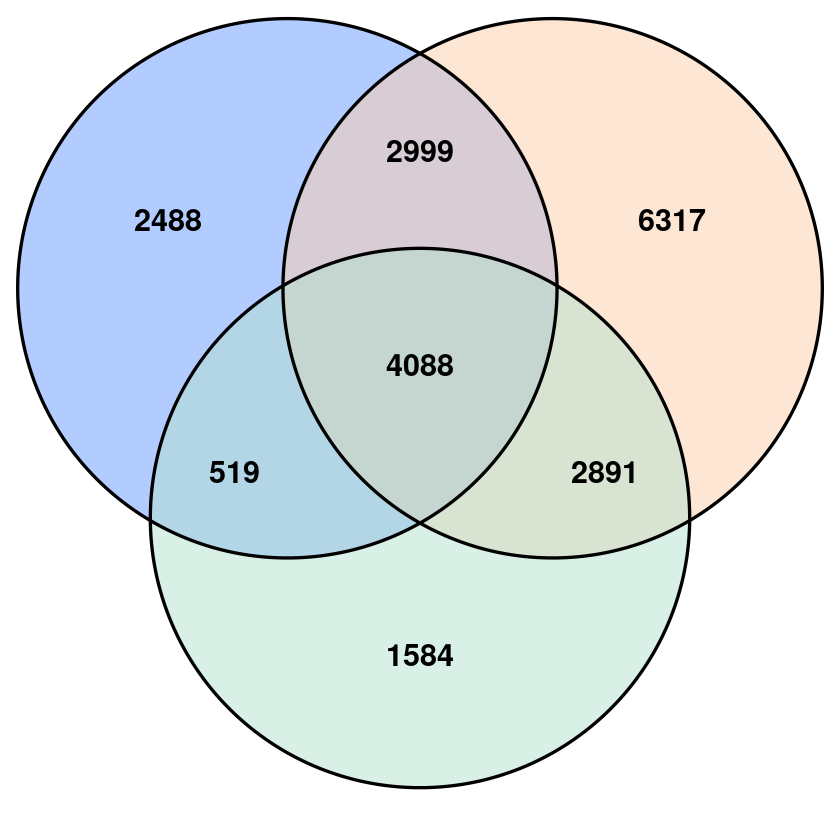

In [34]:
myCol <- c("#6699FF", "#fdcdac", "#b3e2cd")
# area1, area2, area3, n12, n23, n13, n123
venn.plot <- draw.triple.venn(10094, 16295, 9082, 7087, 6979, 4607, 4088, 
                              fill = myCol,
                              alpha = c(.5,.5,.5),
                              cex = 1.5,
                              fontface = 2,
                              fontfamily = rep("sans",7),
                              category = c("", "", ""), 
                              scaled = TRUE)
pdf("../figures/egene2.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

png 
  2

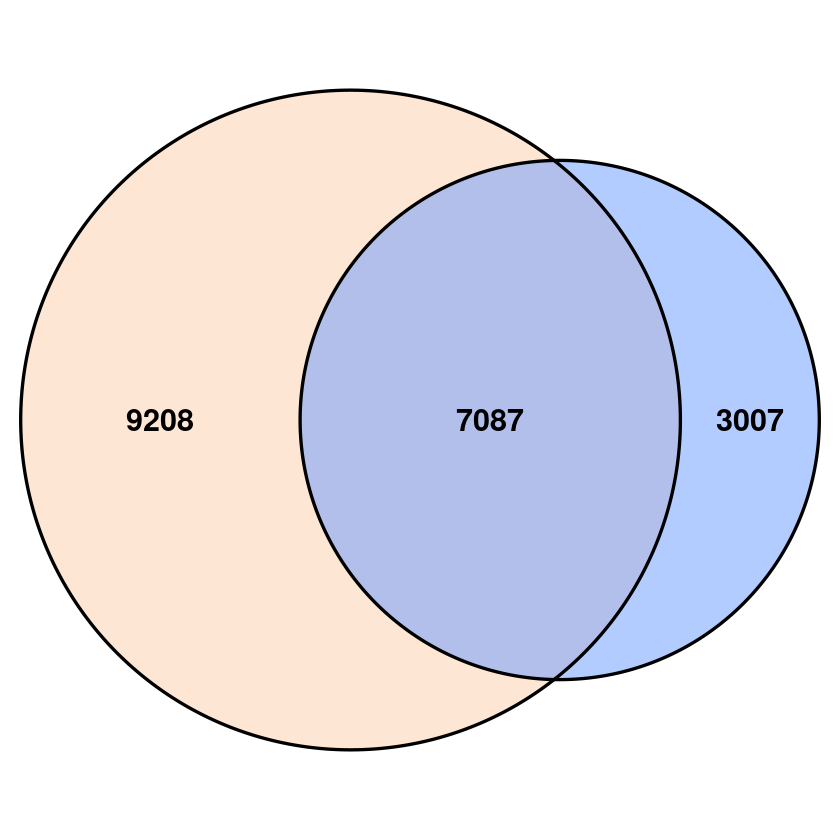

In [51]:
venn.plot <- draw.pairwise.venn(10094, 16295, 7087, 
                                fill = c("#6699FF", "#fdcdac"),
                                alpha = c(0.5,0.5), 
                                cex = 1.5, 
                                fontface = 2, 
                                fontfamily = rep("sans",3), 
                                category=c("", ""),
                                scaled = TRUE)
pdf("../figures/pec_fetal_perm.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

### 2: Nominal eGene
- GTEx does not have nominal associations, only significant gene-SNP pairs based on permutation threshold

In [35]:
fetal_nominal_sig <- fread("../results/mixed_nominal_90hcp/significant_assoc.txt", data.table = F)
head(fetal_nominal_sig)
length(unique(fetal_nominal_sig$pid))

,pid,sid,dist,npval,slope,fdr
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000258162,rs7299713,565454,3.46602e-04,-0.2020930,0.045061559
2,ENSG00000258375,rs6539629,666247,3.36203e-05,0.3712650,0.006459398
3,ENSG00000258375,rs7301748,669071,3.36203e-05,0.3712650,0.006459398
4,ENSG00000258375,rs113125209,673853,2.57610e-04,0.3259410,0.035603251
5,ENSG00000139220,rs12812709,295636,2.42821e-04,-0.0786925,0.033946071
6,ENSG00000127720,rs78374721,-547758,2.90007e-04,0.4310800,0.039127901


[1] 22850

In [38]:
pec_nominal <- read.table("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_nominal/cov.geneHCP100+gPCs20+AllMeta.txt.gz", header = F, stringsAsFactors = F)
head(pec_nominal)

,V1,V2,V3,V4,V5
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,ENSG00000227232,1:927741;rs6665587,913377,0.354833,0.0233520
2,ENSG00000227232,1:928416;rs111754459,914052,0.284998,0.0246471
3,ENSG00000227232,1:930377;rs3128109,916013,0.380292,0.0204835
4,ENSG00000227232,1:931548;rs2799062,917184,0.280460,0.0269167
5,ENSG00000227232,1:935715;rs3128114,921351,0.191151,0.0329024
6,ENSG00000227232,1:938125;rs2710868,923761,0.264899,0.0260760


In [39]:
tail(pec_nominal)

,V1,V2,V3,V4,V5
,<chr>,<chr>,<int>,<dbl>,<dbl>
89062331,ENSG00000232938,17:81047565;rs34713360,-127102,0.770065,-0.0384576
89062332,ENSG00000232938,17:81047638;rs35610241,-127029,0.780744,-0.0366192
89062333,ENSG00000232938,17:81047967;rs141259872,-126700,0.494346,0.0727338
89062334,ENSG00000232938,17:81049229;rs543089390,-125438,0.133864,0.7124540
89062335,ENSG00000232938,17:81060265;rs12939118,-114402,0.817102,-0.0331409
89062336,ENSG00000232938,17:81065254;rs35838070,-109413,0.493237,-0.0970540


In [40]:
colnames(pec_nominal) <- c("pid","sid","dist","npval","slope")
pec_nominal$fdr <- p.adjust(pec_nominal$npval, method = "fdr")
write.table(pec_nominal, "/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_nominal/cov.geneHCP100+gPCs20+AllMeta_assoc.txt",
           quote = F, sep = "\t", col.names = T, row.names = F)
pec_nominal_sig <- pec_nominal %>% filter(fdr < 0.05)
write.table(pec_nominal_sig, "/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_nominal/cov.geneHCP100+gPCs20+AllMeta_sig.txt",
           quote = F, sep = "\t", col.names = T, row.names = F)

In [43]:
length(unique(pec_nominal$pid))
length(unique(pec_nominal_sig$pid))

[1] 24762

[1] 23459

**Somehow the previous files have less genes tested**
- File downloaded from resource site, this is also the file Walker et al. 2019 used

In [44]:
pec_nominal_sig2 <- fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_nominal/DER-08a_hg19_eQTL.significant.txt", data.table = F)
head(pec_nominal_sig2)
length(unique(pec_nominal_sig2$gene_id))
sum(pec_nominal_sig2$FDR < 0.05)

Warning message in fread("/u/project/gandalm/shared/GenomicDatasets/PsychENCODE/xQTL/eQTL/QTLtools_nominal/DER-08a_hg19_eQTL.significant.txt", :
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


,gene_id,gene_chr,gene_start,gene_end,strand,number_of_SNPs_tested,SNP_distance_to_TSS,SNP_id,SNP_chr,SNP_start,SNP_end,nominal_pval,regression_slope,top_SNP,FDR
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,ENSG00000215004.3,chr3,29128887,29128887,+,4558,-365581,3:28763306,chr3,28763306,28763306,0.000270335,0.0886898,1,0.01979050
2,ENSG00000215004.3,chr3,29128887,29128887,+,4558,-364465,3:28764422,chr3,28764422,28764422,0.000344220,0.0868007,0,0.02424459
3,ENSG00000215004.3,chr3,29128887,29128887,+,4558,-364376,3:28764511,chr3,28764511,28764511,0.000523559,0.0841030,0,0.03431670
4,ENSG00000215004.3,chr3,29128887,29128887,+,4558,-357186,3:28771701,chr3,28771701,28771701,0.000606794,0.0861309,0,0.03870841
5,ENSG00000215004.3,chr3,29128887,29128887,+,4558,276595,3:29405482,chr3,29405482,29405482,0.000509309,-0.5076670,0,0.03355055
6,ENSG00000215004.3,chr3,29128887,29128887,+,4558,753189,3:29882076,chr3,29882076,29882076,0.000525076,0.0807715,0,0.03439850


[1] 32944

[1] 2542908

In [45]:
dim(pec_nominal_sig2)

[1] 2542908      15

In [46]:
pec_nominal_sig2 <- pec_nominal_sig2 %>% separate(gene_id, c("gene_ensg", "gene_version"), sep = "[.]", remove = FALSE)

In [48]:
sum(unique(fetal_nominal_sig$pid) %in% unique(pec_nominal_sig2$gene_ensg))

[1] 16525

png 
  2

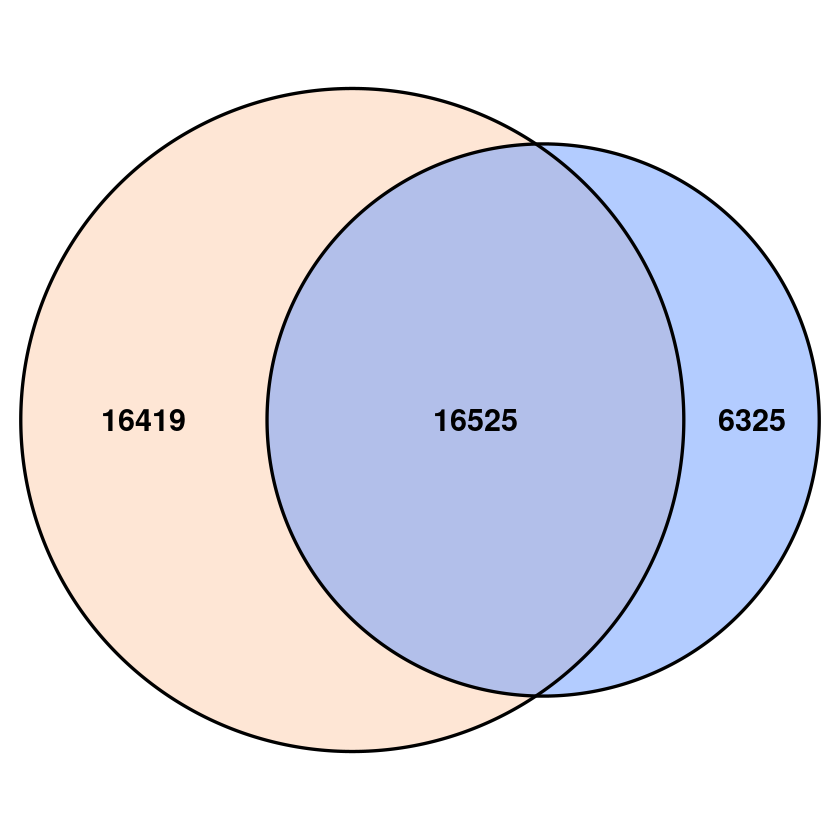

In [50]:
venn.plot <- draw.pairwise.venn(22850, 32944, 16525, 
                                fill = c("#6699FF", "#fdcdac"),
                                alpha = c(0.5,0.5), 
                                cex = 1.5, 
                                fontface = 2, 
                                fontfamily = rep("sans",3), 
                                category=c("", ""),
                                scaled = TRUE)
pdf("../figures/pec_fetal_nominal.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

### 3: eQTL effect size

In [2]:
gtex <- fread("/u/project/gandalm/shared/GenomicDatasets/GTEx/GTEx_Analysis_v8_eQTL/Brain_Cortex.v8.egenes.txt.gz", data.table = F)
head(gtex)

,gene_id,gene_name,gene_chr,gene_start,gene_end,strand,num_var,beta_shape1,beta_shape2,true_df,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,log2_aFC,log2_aFC_lower,log2_aFC_upper
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232.5,WASH7P,chr1,14410,29553,-,1364,1.03067,279.260,150.530,...,6.69151e-05,-2.278650,0.556933,0.03299670,0.034327700,0.037693800,0.000199956,-6.643856,-6.643856,-6.643856
2,ENSG00000268903.1,RP11-34P13.15,chr1,135141,135895,-,1863,1.04288,330.819,147.050,...,8.58837e-04,-0.717460,0.211310,0.40509900,0.401187000,0.213474000,0.000175730,-3.405266,-6.643856,-0.949213
3,ENSG00000269981.1,RP11-34P13.16,chr1,137682,137965,-,1868,1.08579,294.051,142.506,...,2.28982e-03,0.375637,0.121247,0.72641500,0.712026000,0.300460000,0.000226318,0.923909,0.544162,1.196283
4,ENSG00000241860.6,RP11-34P13.13,chr1,141474,173862,-,2066,1.04624,345.849,147.114,...,3.97305e-07,1.189090,0.225087,0.00029997,0.000407264,0.000785933,0.000169942,2.151026,1.857432,2.430742
5,ENSG00000279457.4,RP11-34P13.18,chr1,185217,195411,-,2234,1.04702,378.317,146.873,...,2.18013e-05,-2.441680,0.558590,0.01799820,0.019051200,0.023443700,0.000155753,-6.643856,-6.643856,-6.643856
6,ENSG00000228463.9,AP006222.2,chr1,257864,297502,-,2799,1.05072,461.832,147.775,...,4.70573e-05,-0.911460,0.218017,0.04269570,0.044621000,0.046413300,0.000129125,-6.643856,-6.643856,-6.643856


In [3]:
dim(gtex)
sum(gtex$qval < 0.05)

[1] 24849    33

[1] 9082

In [3]:
gtex.sig <- gtex %>% filter(qval < 0.05)

`geom_smooth()` using formula 'y ~ x'



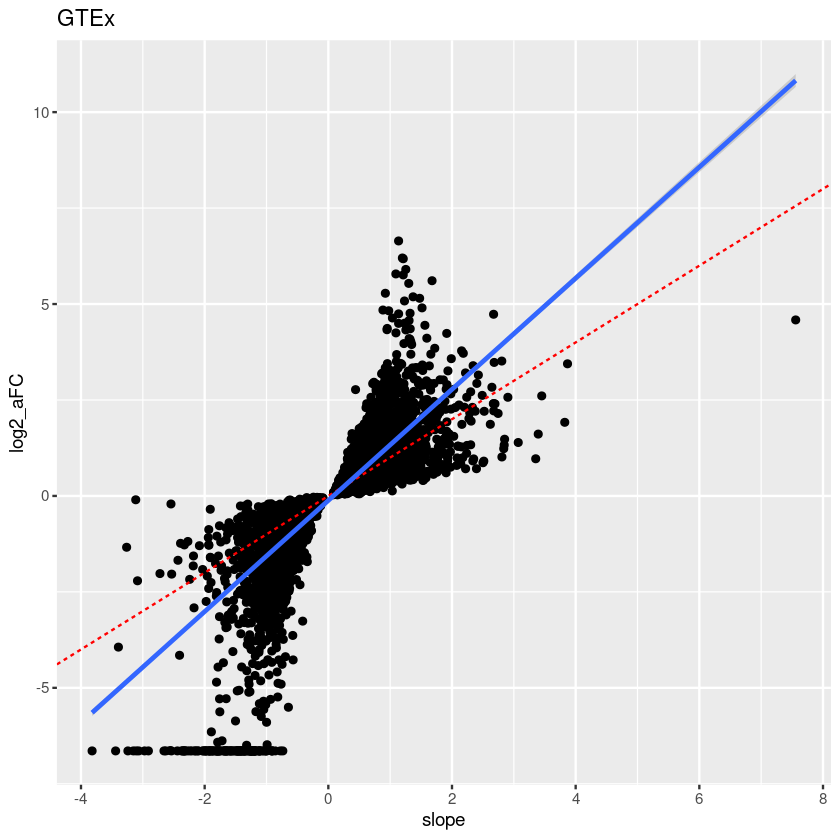

In [25]:
ggplot(gtex.sig, aes(x = slope, y = log2_aFC)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(from = -4, to = 8, by = 2)) +
    geom_smooth(method = "lm") +
    ggtitle("GTEx")

In [4]:
fetal.afc <- fread("../results/mixed_perm_90hcp/aFC_boot100.txt", data.table = F)
head(fetal.afc)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,sid_chr,sid_pos,log2_aFC,log2_aFC_lower,log2_aFC_upper
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,9.999e-05,6.830320000000001e-18,5.86726e-17,5.58582e-05,1,169798745,-0.31334898056130966,-0.3479503110840603,-0.2578372037298595
2,ENSG00000001460,5648,1.04183,862.516,466.17,rs760969,2280,1.3411e-62,-0.657378,9.999e-05,1.67187e-54,8.74e-53,4.95438e-05,1,24745704,-1.2707870503344,-1.4756861824841323,-1.0718926687674037
3,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,9.999e-05,2.93508e-16,2.26687e-15,5.28578e-05,1,24713833,-0.28610242573631117,-0.3389595280398346,-0.24398793288975698
4,ENSG00000004487,5423,1.02622,842.963,469.081,rs12088067,60479,6.45529e-08,-0.204679,0.00049995,0.000247555,0.000585662,4.79319e-05,1,23406415,-0.11774411000290358,-0.15499185818255823,-0.08794296341824745
5,ENSG00000007341,5744,1.04468,832.17,466.739,chr1:112519337,-101488,4.07679e-06,0.163004,0.009999,0.0102504,0.0173421,5.18699e-05,1,113061959,0.056215425296178144,0.034015644578355354,0.08359200854729612
6,ENSG00000008128,5598,1.05888,985.123,466.972,rs114557479,249034,5.82968e-07,-0.55516,0.0009999,0.00184865,0.00372983,4.60375e-05,1,1904830,-0.4929806737554943,-0.7327429127501167,-0.22089186810991876


In [5]:
# fetal.afc <- fetal.afc %>% filter(pid != "pid")
# dim(fetal.afc)
# length(unique(fetal.afc$pid))

[1] 10094    18

[1] 10094

In [6]:
# write.table(fetal.afc, "../results/mixed_perm_90hcp/aFC_boot100.txt", col.names = T, row.names = F, sep = "\t", quote = F)

In [7]:
gtex.sig <- gtex.sig %>% 
    separate(gene_id, c("gene_ensg", "gene_version"), sep = "[.]", remove = FALSE) %>%
    unite("gene_qtl", gene_ensg, rs_id_dbSNP151_GRCh38p7, sep = "-", remove = FALSE)
head(gtex.sig)

,gene_id,gene_qtl,gene_ensg,gene_version,gene_name,gene_chr,gene_start,gene_end,strand,num_var,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,log2_aFC,log2_aFC_lower,log2_aFC_upper
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000227232.5,ENSG00000227232-rs375227545,ENSG00000227232,5,WASH7P,chr1,14410,29553,-,1364,...,6.69151e-05,-2.27865,0.556933,0.03299670,0.034327700,0.037693800,0.000199956,-6.643856,-6.643856,-6.643856
2,ENSG00000241860.6,ENSG00000241860-rs201327123,ENSG00000241860,6,RP11-34P13.13,chr1,141474,173862,-,2066,...,3.97305e-07,1.18909,0.225087,0.00029997,0.000407264,0.000785933,0.000169942,2.151026,1.857432,2.430742
3,ENSG00000279457.4,ENSG00000279457-rs879428059,ENSG00000279457,4,RP11-34P13.18,chr1,185217,195411,-,2234,...,2.18013e-05,-2.44168,0.558590,0.01799820,0.019051200,0.023443700,0.000155753,-6.643856,-6.643856,-6.643856
4,ENSG00000228463.9,ENSG00000228463-rs201327123,ENSG00000228463,9,AP006222.2,chr1,257864,297502,-,2799,...,4.70573e-05,-0.91146,0.218017,0.04269570,0.044621000,0.046413300,0.000129125,-6.643856,-6.643856,-6.643856
5,ENSG00000225972.1,ENSG00000225972-rs75333668,ENSG00000225972,1,MTND1P23,chr1,629062,629433,+,4328,...,1.57958e-07,1.21144,0.221144,0.00039996,0.000323757,0.000636598,0.000101975,5.758088,3.039754,6.643856
6,ENSG00000225630.1,ENSG00000225630-rs114783599,ENSG00000225630,1,MTND2P28,chr1,629640,630683,+,4331,...,1.48934e-05,-1.40386,0.314531,0.02089790,0.021985400,0.026290800,0.000095717,-6.643856,-6.643856,-6.643856


In [8]:
length(unique(gtex.sig$gene_qtl))

[1] 9082

In [9]:
fetal.afc <- fetal.afc %>%
    unite("gene_qtl", pid, sid, sep = "-", remove = FALSE)
head(fetal.afc)
length(unique(fetal.afc$gene_qtl))

,gene_qtl,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,sid_chr,sid_pos,log2_aFC,log2_aFC_lower,log2_aFC_upper
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000000460-rs17529513,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,9.999e-05,6.830320000000001e-18,5.86726e-17,5.58582e-05,1,169798745,-0.31334898056130966,-0.3479503110840603,-0.2578372037298595
2,ENSG00000001460-rs760969,ENSG00000001460,5648,1.04183,862.516,466.17,rs760969,2280,1.3411e-62,-0.657378,9.999e-05,1.67187e-54,8.74e-53,4.95438e-05,1,24745704,-1.2707870503344,-1.4756861824841323,-1.0718926687674037
3,ENSG00000001461-rs497071,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,9.999e-05,2.93508e-16,2.26687e-15,5.28578e-05,1,24713833,-0.28610242573631117,-0.3389595280398346,-0.24398793288975698
4,ENSG00000004487-rs12088067,ENSG00000004487,5423,1.02622,842.963,469.081,rs12088067,60479,6.45529e-08,-0.204679,0.00049995,0.000247555,0.000585662,4.79319e-05,1,23406415,-0.11774411000290358,-0.15499185818255823,-0.08794296341824745
5,ENSG00000007341-chr1:112519337,ENSG00000007341,5744,1.04468,832.17,466.739,chr1:112519337,-101488,4.07679e-06,0.163004,0.009999,0.0102504,0.0173421,5.18699e-05,1,113061959,0.056215425296178144,0.034015644578355354,0.08359200854729612
6,ENSG00000008128-rs114557479,ENSG00000008128,5598,1.05888,985.123,466.972,rs114557479,249034,5.82968e-07,-0.55516,0.0009999,0.00184865,0.00372983,4.60375e-05,1,1904830,-0.4929806737554943,-0.7327429127501167,-0.22089186810991876


[1] 10094

In [10]:
sum(gtex.sig$gene_qtl %in% fetal.afc$gene_qtl)

[1] 251

In [20]:
fetal.afc$slope <- as.numeric(fetal.afc$slope)
fetal.afc$log2_aFC <- as.numeric(fetal.afc$log2_aFC)
fetal.afc$log2_aFC_upper <- as.numeric(fetal.afc$log2_aFC_upper)
fetal.afc$log2_aFC_lower <- as.numeric(fetal.afc$log2_aFC_lower)

`geom_smooth()` using formula 'y ~ x'



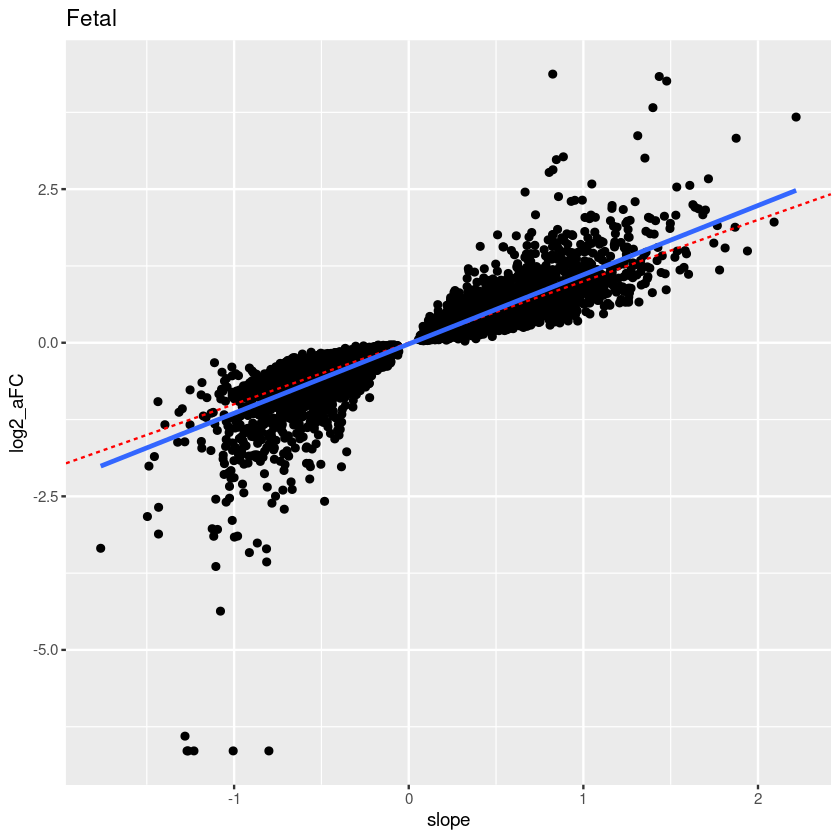

In [12]:
ggplot(fetal.afc, aes(x = slope, y = log2_aFC)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
    scale_x_continuous(breaks = seq(from = -4, to = 8, by = 1)) +
    geom_smooth(method = "lm") +
    ggtitle("Fetal")

In [21]:
shared <- fetal.afc %>% inner_join(gtex.sig, by = "gene_qtl")
dim(shared)

[1] 251  54

In [18]:
colnames(shared)

[1] "gene_qtl"                 "pid"                     
 [3] "nvar"                     "shape1"                  
 [5] "shape2"                   "dummy"                   
 [7] "sid"                      "dist"                    
 [9] "npval"                    "slope.x"                 
[11] "ppval"                    "bpval"                   
[13] "qval.x"                   "pval_nominal_threshold.x"
[15] "sid_chr"                  "sid_pos"                 
[17] "log2_aFC.x"               "log2_aFC_lower.x"        
[19] "log2_aFC_upper.x"         "gene_id"                 
[21] "gene_ensg"                "gene_version"            
[23] "gene_name"                "gene_chr"                
[25] "gene_start"               "gene_end"                
[27] "strand"                   "num_var"                 
[29] "beta_shape1"              "beta_shape2"             
[31] "true_df"                  "pval_true_df"            
[33] "variant_id"               "tss_distance"            
[35] "chr"                      "variant_pos"             
[37] "ref"                      "alt"                     
[39] "num_alt_per_site"         "rs_id_dbSNP151_GRCh38p7" 
[41] "minor_allele_samples"     "minor_allele_count"      
[43] "maf"                      "ref_factor"              
[45] "pval_nominal"             "slope.y"                 
[47] "slope_se"                 "pval_perm"               
[49] "pval_beta"                "qval.y"                  
[51] "pval_nominal_threshold.y" "log2_aFC.y"              
[53] "log2_aFC_lower.y"         "log2_aFC_upper.y"

`geom_smooth()` using formula 'y ~ x'



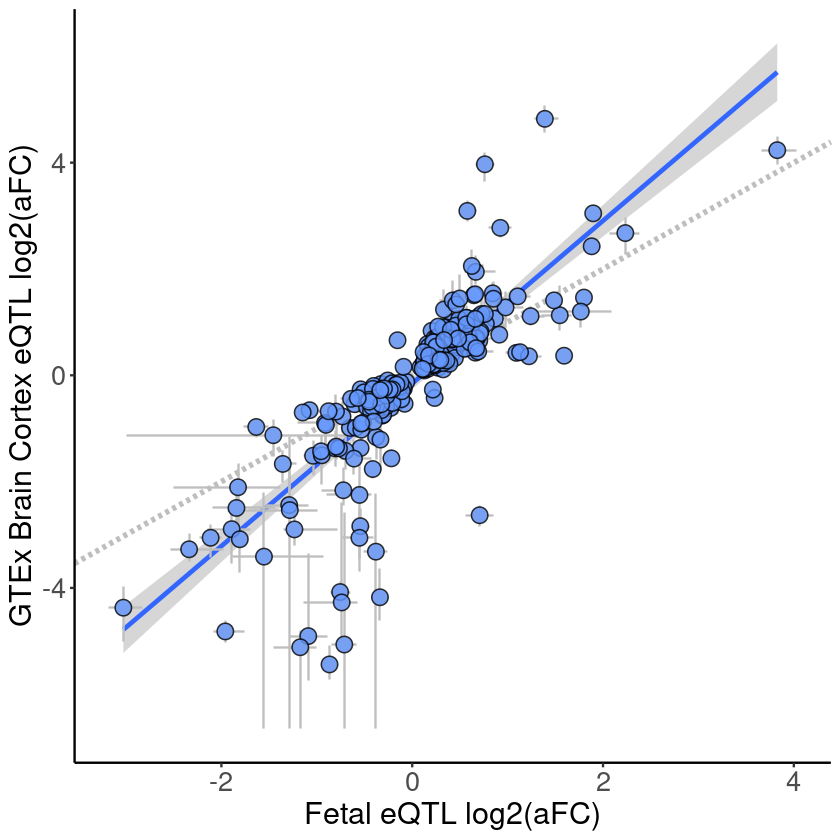

In [33]:
range

In [28]:
ggsave("../figures/fetal_gtex_aFC.pdf", width = 6, height = 6)

`geom_smooth()` using formula 'y ~ x'



In [29]:
cor(shared$log2_aFC.x, shared$log2_aFC.y, method = "spearman")
cor(shared$slope.x, shared$slope.y, method = "spearman")

[1] 0.9119856

[1] 0.8823108

`geom_smooth()` using formula 'y ~ x'



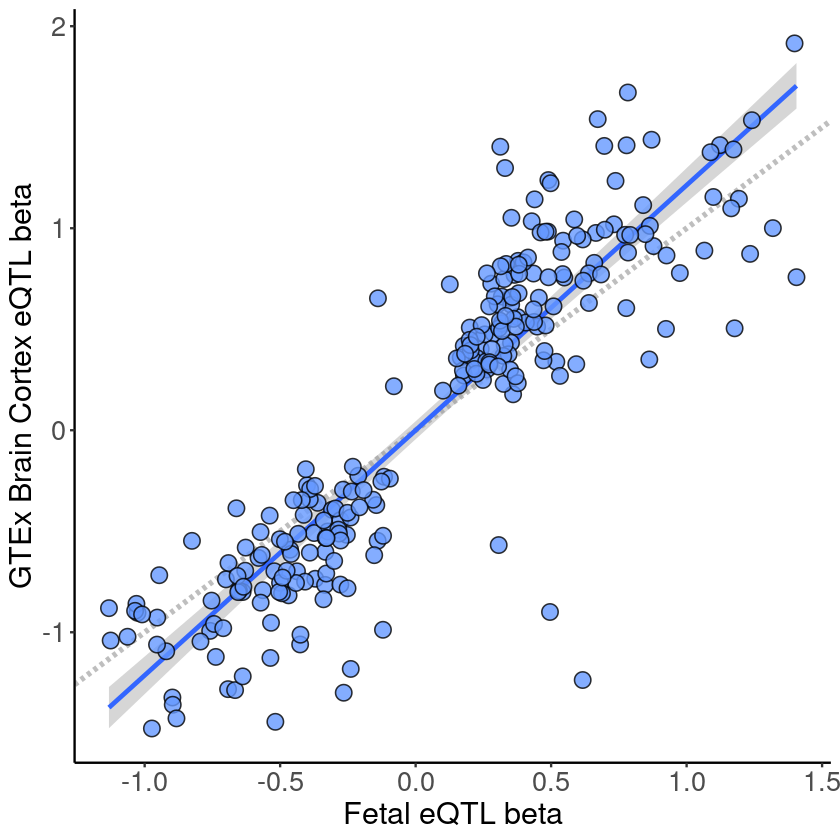

In [30]:
ggplot(shared, aes(x = slope.x, y = slope.y)) +
    geom_abline(intercept = 0, slope = 1, color = "grey", linetype = "dashed", size = 1.2) +
    geom_smooth(method = "lm") +
    geom_point(size = 4, fill = "#6699FF", shape = 21, alpha = 0.8) +
    labs(x = "Fetal eQTL beta", y = "GTEx Brain Cortex eQTL beta") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18))

In [31]:
ggsave("../figures/fetal_gtex_beta.pdf", width = 6, height = 6)

`geom_smooth()` using formula 'y ~ x'

